### EEG Modeling to Predict Six Major Psychiatric Disorders

### 1. Business Understanding

Mental health disorders are often difficult to diagnose, sometimes taking months and years of assessment and treatment depending on the emerging disorder.  It is a time intensive process for the individuals who need care and for their families. With that added time comes increased out of pocket costs for doctor’s visits - potentially from multiple providers - and loss of income from having to take time off of work.  Psychiatrists and clinical psychologists are often booked out months in advance for appointments. It may take an acute mental health crisis that leads to hospitalization to speed up treatment and diagnosis of the suffering individual. Earlier diagnosis is needed. 

Routine tests such as Electroencephalograms (EEG), which detect abnormalities in brain waves, traditionally have been used to diagnose epilepsy, Alzheimer's disease, sleep disorders, and brain tumors. EEGs have also been helpful to identify underlying causes of psychosis, a condition marked by a loss of some contact with reality. EEG data is being explored further to identify a broader range of psychiatric conditions - schizophrenia, addictive disorders, anxiety disorders, traumatic stress disorders, and obsessive compulsive disorders. EEGs may offer a path to earlier diagnosis for some psychiatric conditions.


### Sourcing Data - 

The data for this modeling project comes from recent work conducted by researchers in South Korea who gathered resting state EEG data from nearly 1000 patients. These adult patients suffer from six major psychiatric disorders. 

The raw data is accessible through the Center for Open Science’s data portal located at https://osf.io/.  The dataset size is 10.5 MB in csv format making it easy to use locally.  There are over 1000 features making this a rather large dataset.  The features consist of some basic patient data such as sex, age, education level and psychiatric diagnosis.  The remaining features consists of multiple brain wavelength readings at 19 different contact points on the skull. 

### 2. Load Packages and Data

In [71]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, recall_score, accuracy_score, precision_score, f1_score


import pickle

from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

In [2]:
#Load data and display
df = pd.read_csv('EEG.machinelearing_data_BRMH.csv')
df.head()

,no.,sex,age,eeg.date,education,IQ,main.disorder,specific.disorder,AB.A.delta.a.FP1,AB.A.delta.b.FP2,...,COH.F.gamma.o.Pz.p.P4,COH.F.gamma.o.Pz.q.T6,COH.F.gamma.o.Pz.r.O1,COH.F.gamma.o.Pz.s.O2,COH.F.gamma.p.P4.q.T6,COH.F.gamma.p.P4.r.O1,COH.F.gamma.p.P4.s.O2,COH.F.gamma.q.T6.r.O1,COH.F.gamma.q.T6.s.O2,COH.F.gamma.r.O1.s.O2
0,1,M,57.0,2012.8.30,NaN,NaN,Addictive disorder,Alcohol use disorder,35.998557,21.717375,...,55.989192,16.739679,23.452271,45.678820,30.167520,16.918761,48.850427,9.422630,34.507082,28.613029
1,2,M,37.0,2012.9.6,6.0,120.0,Addictive disorder,Alcohol use disorder,13.425118,11.002916,...,45.595619,17.510824,26.777368,28.201062,57.108861,32.375401,60.351749,13.900981,57.831848,43.463261
2,3,M,32.0,2012.9.10,16.0,113.0,Addictive disorder,Alcohol use disorder,29.941780,27.544684,...,99.475453,70.654171,39.131547,69.920996,71.063644,38.534505,69.908764,27.180532,64.803155,31.485799
3,4,M,35.0,2012.10.8,18.0,126.0,Addictive disorder,Alcohol use disorder,21.496226,21.846832,...,59.986561,63.822201,36.478254,47.117006,84.658376,24.724096,50.299349,35.319695,79.822944,41.141873
4,5,M,36.0,2012.10.18,16.0,112.0,Addictive disorder,Alcohol use disorder,37.775667,33.607679,...,61.462720,59.166097,51.465531,58.635415,80.685608,62.138436,75.888749,61.003944,87.455509,70.531662


In [3]:
#set option to display all columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
df.head(5)

,no.,sex,age,eeg.date,education,IQ,main.disorder,specific.disorder,AB.A.delta.a.FP1,AB.A.delta.b.FP2,AB.A.delta.c.F7,AB.A.delta.d.F3,AB.A.delta.e.Fz,AB.A.delta.f.F4,AB.A.delta.g.F8,AB.A.delta.h.T3,AB.A.delta.i.C3,AB.A.delta.j.Cz,AB.A.delta.k.C4,AB.A.delta.l.T4,AB.A.delta.m.T5,AB.A.delta.n.P3,AB.A.delta.o.Pz,AB.A.delta.p.P4,AB.A.delta.q.T6,AB.A.delta.r.O1,AB.A.delta.s.O2,AB.B.theta.a.FP1,AB.B.theta.b.FP2,AB.B.theta.c.F7,AB.B.theta.d.F3,AB.B.theta.e.Fz,AB.B.theta.f.F4,AB.B.theta.g.F8,AB.B.theta.h.T3,AB.B.theta.i.C3,AB.B.theta.j.Cz,AB.B.theta.k.C4,AB.B.theta.l.T4,AB.B.theta.m.T5,AB.B.theta.n.P3,AB.B.theta.o.Pz,AB.B.theta.p.P4,AB.B.theta.q.T6,AB.B.theta.r.O1,AB.B.theta.s.O2,AB.C.alpha.a.FP1,AB.C.alpha.b.FP2,AB.C.alpha.c.F7,AB.C.alpha.d.F3,AB.C.alpha.e.Fz,AB.C.alpha.f.F4,AB.C.alpha.g.F8,AB.C.alpha.h.T3,AB.C.alpha.i.C3,AB.C.alpha.j.Cz,AB.C.alpha.k.C4,AB.C.alpha.l.T4,AB.C.alpha.m.T5,AB.C.alpha.n.P3,AB.C.alpha.o.Pz,AB.C.alpha.p.P4,AB.C.alpha.q.T6,AB.C.alpha.r.O1,AB.C.alpha.s.O2,AB.D.beta.a.FP1,AB.D.beta.b.FP2,AB.D.beta.c.F7,AB.D.beta.d.F3,AB.D.beta.e.Fz,AB.D.beta.f.F4,AB.D.beta.g.F8,AB.D.beta.h.T3,AB.D.beta.i.C3,AB.D.beta.j.Cz,AB.D.beta.k.C4,AB.D.beta.l.T4,AB.D.beta.m.T5,AB.D.beta.n.P3,AB.D.beta.o.Pz,AB.D.beta.p.P4,AB.D.beta.q.T6,AB.D.beta.r.O1,AB.D.beta.s.O2,AB.E.highbeta.a.FP1,AB.E.highbeta.b.FP2,AB.E.highbeta.c.F7,AB.E.highbeta.d.F3,AB.E.highbeta.e.Fz,AB.E.highbeta.f.F4,AB.E.highbeta.g.F8,AB.E.highbeta.h.T3,AB.E.highbeta.i.C3,AB.E.highbeta.j.Cz,AB.E.highbeta.k.C4,AB.E.highbeta.l.T4,AB.E.highbeta.m.T5,AB.E.highbeta.n.P3,AB.E.highbeta.o.Pz,AB.E.highbeta.p.P4,AB.E.highbeta.q.T6,AB.E.highbeta.r.O1,AB.E.highbeta.s.O2,AB.F.gamma.a.FP1,AB.F.gamma.b.FP2,AB.F.gamma.c.F7,AB.F.gamma.d.F3,AB.F.gamma.e.Fz,AB.F.gamma.f.F4,AB.F.gamma.g.F8,AB.F.gamma.h.T3,AB.F.gamma.i.C3,AB.F.gamma.j.Cz,AB.F.gamma.k.C4,AB.F.gamma.l.T4,AB.F.gamma.m.T5,AB.F.gamma.n.P3,AB.F.gamma.o.Pz,AB.F.gamma.p.P4,AB.F.gamma.q.T6,AB.F.gamma.r.O1,AB.F.gamma.s.O2,Unnamed: 122,COH.A.delta.a.FP1.b.FP2,COH.A.delta.a.FP1.c.F7,COH.A.delta.a.FP1.d.F3,COH.A.delta.a.FP1.e.Fz,COH.A.delta.a.FP1.f.F4,COH.A.delta.a.FP1.g.F8,COH.A.delta.a.FP1.h.T3,COH.A.delta.a.FP1.i.C3,COH.A.delta.a.FP1.j.Cz,COH.A.delta.a.FP1.k.C4,COH.A.delta.a.FP1.l.T4,COH.A.delta.a.FP1.m.T5,COH.A.delta.a.FP1.n.P3,COH.A.delta.a.FP1.o.Pz,COH.A.delta.a.FP1.p.P4,COH.A.delta.a.FP1.q.T6,COH.A.delta.a.FP1.r.O1,COH.A.delta.a.FP1.s.O2,COH.A.delta.b.FP2.c.F7,COH.A.delta.b.FP2.d.F3,COH.A.delta.b.FP2.e.Fz,COH.A.delta.b.FP2.f.F4,COH.A.delta.b.FP2.g.F8,COH.A.delta.b.FP2.h.T3,COH.A.delta.b.FP2.i.C3,COH.A.delta.b.FP2.j.Cz,COH.A.delta.b.FP2.k.C4,COH.A.delta.b.FP2.l.T4,COH.A.delta.b.FP2.m.T5,COH.A.delta.b.FP2.n.P3,COH.A.delta.b.FP2.o.Pz,COH.A.delta.b.FP2.p.P4,COH.A.delta.b.FP2.q.T6,COH.A.delta.b.FP2.r.O1,COH.A.delta.b.FP2.s.O2,COH.A.delta.c.F7.d.F3,COH.A.delta.c.F7.e.Fz,COH.A.delta.c.F7.f.F4,COH.A.delta.c.F7.g.F8,COH.A.delta.c.F7.h.T3,COH.A.delta.c.F7.i.C3,COH.A.delta.c.F7.j.Cz,COH.A.delta.c.F7.k.C4,COH.A.delta.c.F7.l.T4,COH.A.delta.c.F7.m.T5,COH.A.delta.c.F7.n.P3,COH.A.delta.c.F7.o.Pz,COH.A.delta.c.F7.p.P4,COH.A.delta.c.F7.q.T6,COH.A.delta.c.F7.r.O1,COH.A.delta.c.F7.s.O2,COH.A.delta.d.F3.e.Fz,COH.A.delta.d.F3.f.F4,COH.A.delta.d.F3.g.F8,COH.A.delta.d.F3.h.T3,COH.A.delta.d.F3.i.C3,COH.A.delta.d.F3.j.Cz,COH.A.delta.d.F3.k.C4,COH.A.delta.d.F3.l.T4,COH.A.delta.d.F3.m.T5,COH.A.delta.d.F3.n.P3,COH.A.delta.d.F3.o.Pz,COH.A.delta.d.F3.p.P4,COH.A.delta.d.F3.q.T6,COH.A.delta.d.F3.r.O1,COH.A.delta.d.F3.s.O2,COH.A.delta.e.Fz.f.F4,COH.A.delta.e.Fz.g.F8,COH.A.delta.e.Fz.h.T3,COH.A.delta.e.Fz.i.C3,COH.A.delta.e.Fz.j.Cz,COH.A.delta.e.Fz.k.C4,COH.A.delta.e.Fz.l.T4,COH.A.delta.e.Fz.m.T5,COH.A.delta.e.Fz.n.P3,COH.A.delta.e.Fz.o.Pz,COH.A.delta.e.Fz.p.P4,COH.A.delta.e.Fz.q.T6,COH.A.delta.e.Fz.r.O1,COH.A.delta.e.Fz.s.O2,COH.A.delta.f.F4.g.F8,COH.A.delta.f.F4.h.T3,COH.A.delta.f.F4.i.C3,COH.A.delta.f.F4.j.Cz,COH.A.delta.f.F4.k.C4,COH.A.delta.f.F4.l.T4,COH.A.delta.f.F4.m.T5,COH.A.delta.f.F4.n.P3,COH.A.delta.f.F4.o.Pz,COH.A.delta.f.F4.p.P4,COH.A.delta.f.F4.q.T6,COH.A.de

### 3. Data Understanding

#### Data Description

Patient Data
 * no. - patient unique id number
 * sex
 * age
 * eeg.date - Date assessment administered
 * education - years of education level
 * IQ - intelligence quotient, general score
 * main.disorder - Primary Psychiatric Diagnosis
 * specific.disorder - Specific disorder under main disorder

EEG Data
 
 * QEEG PSD ('AB' features) - absolute power value in each frequency band
 * QEEG FC ('COH' features) - coherence for each band and channel 

More detailed description of data available on data sheet from the study

https://www.frontiersin.org/articles/10.3389/fpsyt.2021.707581/full#supplementary-material


#### Describe data 

In [6]:
#Identify missing data
missing = df.isna().sum()
missing[missing >0]

education        15
IQ               13
Unnamed: 122    945
dtype: int64

In [7]:
#Display datatypes  by feature

print(df.info())
datatypes = df.dtypes
print()
print(datatypes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 945 entries, 0 to 944
Columns: 1149 entries, no. to COH.F.gamma.r.O1.s.O2
dtypes: float64(1144), int64(1), object(4)
memory usage: 8.3+ MB
None

no.                             int64
sex                            object
age                           float64
eeg.date                       object
education                     float64
IQ                            float64
main.disorder                  object
specific.disorder              object
AB.A.delta.a.FP1              float64
AB.A.delta.b.FP2              float64
AB.A.delta.c.F7               float64
AB.A.delta.d.F3               float64
AB.A.delta.e.Fz               float64
AB.A.delta.f.F4               float64
AB.A.delta.g.F8               float64
AB.A.delta.h.T3               float64
AB.A.delta.i.C3               float64
AB.A.delta.j.Cz               float64
AB.A.delta.k.C4               float64
AB.A.delta.l.T4               float64
AB.A.delta.m.T5               float64
AB.A.de

In [8]:
# print shape of data
print ('Shape of the data: Rows x Columns', df.shape)

Shape of the data: Rows x Columns (945, 1149)


In [9]:
# Pull summary descriptive stats for dataframe
df.describe()

no.         age   education          IQ  AB.A.delta.a.FP1  \
count  945.000000  945.000000  930.000000  932.000000        945.000000   
mean   473.000000   30.594804   13.438710  101.580472         20.182936   
std    272.942302   11.781592    2.550461   17.022414         11.282022   
min      1.000000   18.000000    0.000000   49.000000          3.272260   
25%    237.000000   21.730000   12.000000   91.000000         12.784872   
50%    473.000000   26.150000   13.000000  102.000000         17.065286   
75%    709.000000   35.450000   16.000000  114.000000         24.492760   
max    945.000000   71.880000   20.000000  145.000000         92.826192   

       AB.A.delta.b.FP2  AB.A.delta.c.F7  AB.A.delta.d.F3  AB.A.delta.e.Fz  \
count        945.000000       945.000000       945.000000       945.000000   
mean          21.177584        17.749553        18.901698        20.447079   
std           12.230662        10.003598         9.079482         9.742912   
min            3.244199         3.050507         3.412618         5.066593   
25%           13.019269        11.134327        12.460586        13.548645   
50%           17.838251        15.541469        16.733004        18.065276   
75%           25.654394        21.623961        23.347900        25.573096   
max          101.515687        91.373456        82.544167       101.566662   

       AB.A.delta.f.F4  AB.A.delta.g.F8  AB.A.delta.h.T3  AB.A.delta.i.C3  \
count       945.000000       945.000000       945.000000       945.000000   
mean         19.490329        17.042218        11.790176        16.405732   
std           9.252500         9.272096         7.347929         8.246200   
min           4.048931         2.552213         2.128977         2.213470   
25%          12.637717        10.381770         7.042545        10.686639   
50%          17.432568        15.050377        10.044354        14.525494   
75%          23.956748        20.810308        14.246874        20.271380   
max          77.197502        69.071230        77.283412        65.932521   

       AB.A.delta.j.Cz  AB.A.delta.k.C4  AB.A.delta.l.T4  AB.A.delta.m.T5  \
count       945.000000       945.000000       945.000000       945.000000   
mean         19.566879        17.170369        12.303086        10.937286   
std           9.525142         8.450513         7.399613         7.268041   
min           3.149313         2.421924         1.899937         0.377075   
25%          13.130418        11.138735         7.377093         6.129184   
50%          17.245633        15.379709        10.393380         9.016449   
75%          23.792159        21.160179        14.891855        13.268871   
max          88.474026        65.449609        58.976481        59.076361   

       AB.A.delta.n.P3  AB.A.delta.o.Pz  AB.A.delta.p.P4  AB.A.delta.q.T6  \
count       945.000000       945.000000       945.000000       945.000000   
mean         14.891539        17.023643        16.211828        13.111305   
std           8.576411         9.456696         8.949209         8.752174   
min           3.010977         3.441543         2.653825         1.959439   
25%           9.117581        10.756015         9.980880         7.249005   
50%          12.605893        14.833858        13.963608        11.044359   
75%          18.806315        20.986275        20.188738        16.038445   
max          83.137188        93.898427        90.628374        68.939248   

       AB.A.delta.r.O1  AB.A.delta.s.O2  AB.B.theta.a.FP1  AB.B.theta.b.FP2  \
count       945.000000       945.000000        945.000000        945.000000   
mean         12.702477        12.969796         13.715181         14.293441   
std           8.874212         8.719749         10.257616         10.837731   
min           1.584043         1.774151          2.781916          2.727408   
25%           6.763807         7.215741          7.934988          8.252628   
50%          10.360117        10.752521         11.272977         11.719087   


#### Value Counts for Categorical Data

In [10]:
# Gender counts
df['sex'].value_counts()

M    601
F    344
Name: sex, dtype: int64

Text(0.5, 1.0, 'Record Count by Gender')

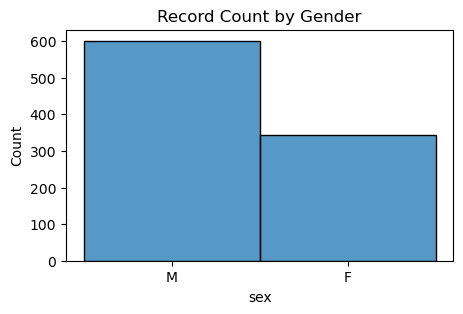

In [11]:
# Plot records by gender
fig = plt.figure(figsize = (5,3))

sns.histplot(df['sex'])
plt.title("Record Count by Gender")

In [12]:
# Main disorder counts
df['main.disorder'].value_counts()

Mood disorder                         266
Addictive disorder                    186
Trauma and stress related disorder    128
Schizophrenia                         117
Anxiety disorder                      107
Healthy control                        95
Obsessive compulsive disorder          46
Name: main.disorder, dtype: int64

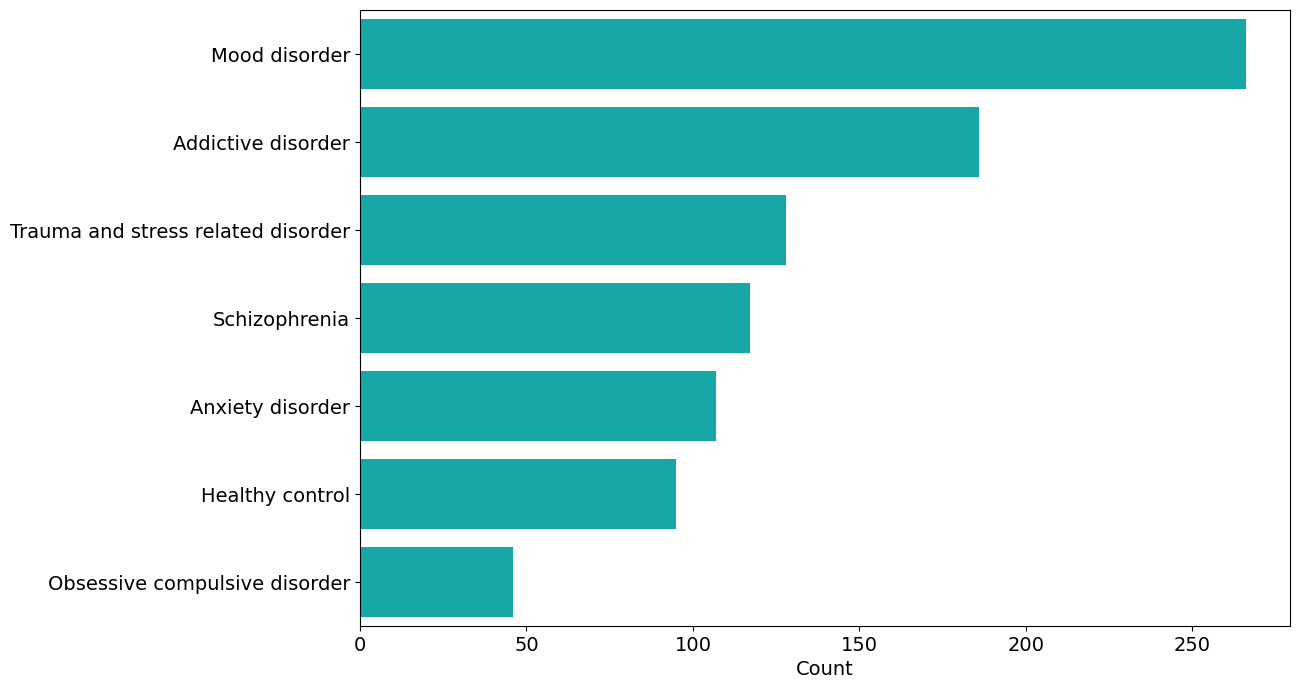

In [13]:
#Plot value counts for main disorders

fig = plt.figure(figsize=(12,8))

sns.countplot(y = 'main.disorder', data = df, color = 'c',
              order = df['main.disorder'].value_counts().index)

plt.xticks(size = 14)
plt.yticks(size = 14)
plt.xlabel('Count', size = 14)
plt.ylabel(None)

plt.savefig("Psychiatric_Classes.png")
plt.show();

In [14]:
# Specific disorder by count
df['specific.disorder'].value_counts()

Depressive disorder               199
Schizophrenia                     117
Healthy control                    95
Alcohol use disorder               93
Behavioral addiction disorder      93
Bipolar disorder                   67
Panic disorder                     59
Posttraumatic stress disorder      52
Social anxiety disorder            48
Obsessive compulsitve disorder     46
Acute stress disorder              38
Adjustment disorder                38
Name: specific.disorder, dtype: int64

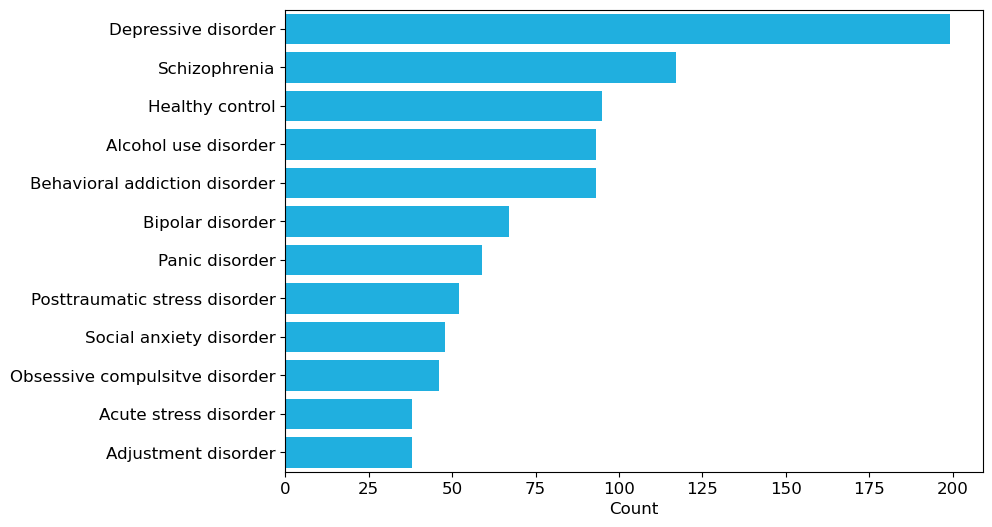

In [15]:
#Plot value counts for specific disorders

fig = plt.figure(figsize=(9,6))

sns.countplot(y = 'specific.disorder', data = df, color = 'deepskyblue',
              order = df['specific.disorder'].value_counts().index)

plt.xticks(size = 12)
plt.yticks(size = 12)
plt.xlabel('Count', size = 12)
plt.ylabel(None)

plt.show();

### Exploratory Data Analysis

Patient Background Data - Age, Sex, Education, and IQ Distribution. Compare diagnosis by age, sex, and education

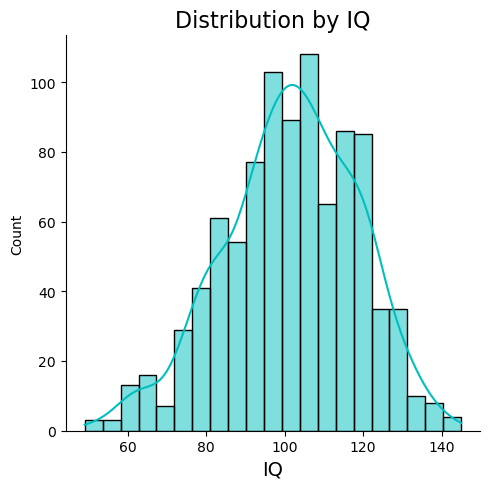

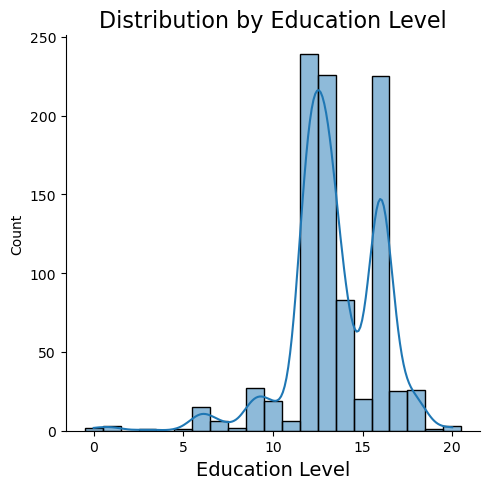

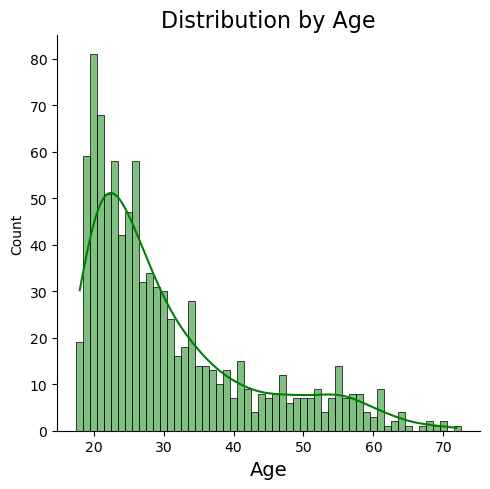

In [24]:
# Check distribution patterns for age, education, and IQ

plt.rcParams["figure.figsize"] = [7.00, 7.00]
plt.rcParams["figure.autolayout"] = True


#IQ
sns.displot(df['IQ'], kde = True, color = 'c')
plt.title('Distribution by IQ', size = 16)
plt.xlabel('IQ', size = 14)

#Education
sns.displot(df['education'], discrete = True, kde = True)
plt.title('Distribution by Education Level', size = 16)
plt.xlabel('Education Level', size = 14)

#Age
sns.displot(df['age'], discrete = True, kde = True, color = 'green')
plt.title('Distribution by Age', size = 16)
plt.xlabel('Age', size = 14)

plt.show();

<Figure size 1600x1200 with 0 Axes>

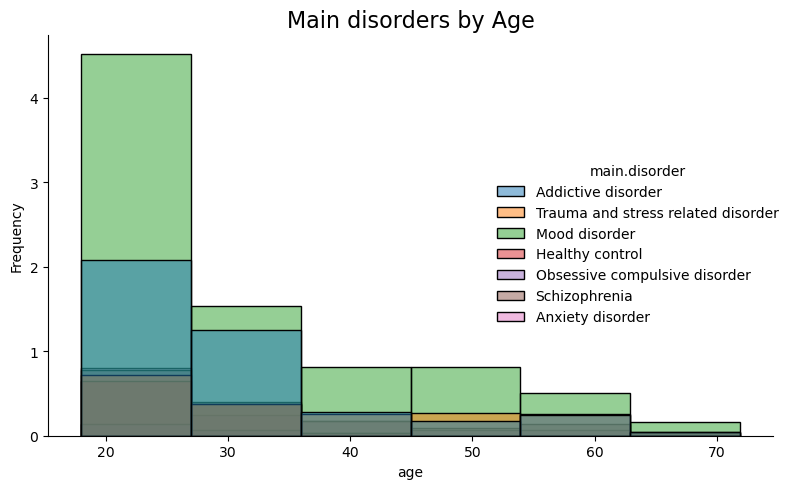

In [25]:
#Plot main disorder against age
fig = plt.figure(figsize = (16, 12))
sns.displot(data = df, x = df['age'], hue = 'main.disorder', stat = 'frequency', bins = 6)
plt.title('Main disorders by Age', size = 16)

fig.tight_layout()
plt.show();

Text(0.5, 1.0, 'Mood Disorder by Gender')

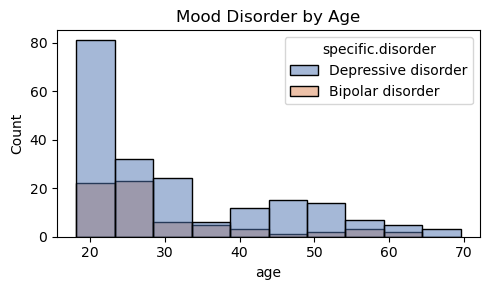

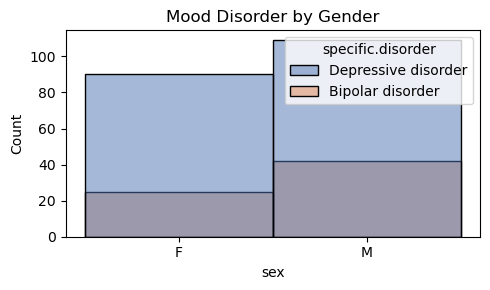

In [26]:
# Plot showing specific mood disorders by age

df_mood = df.loc[df['main.disorder'].isin(['Mood disorder'])]
fig = plt.figure(figsize=(5,3))
           
sns.histplot(data = df_mood, x = df_mood['age'], hue = 'specific.disorder', 
            palette = 'deep')
plt.title('Mood Disorder by Age')
# stacked bargraph for specific disorder by gender

fig = plt.figure(figsize=(5,3))
           
sns.histplot(data = df_mood, x = df_mood['sex'], hue = 'specific.disorder',
            palette = 'deep')
plt.title('Mood Disorder by Gender')

#### Node reference - based on the 10-20 system
Diagram displaying node placement on skull for 21 nodes. For this experiment there were 19 node placements, Fpz and Oz were not used. 

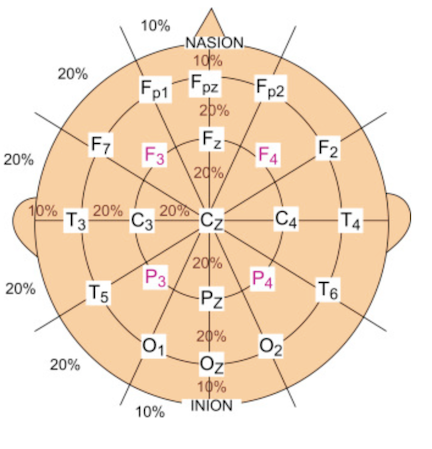

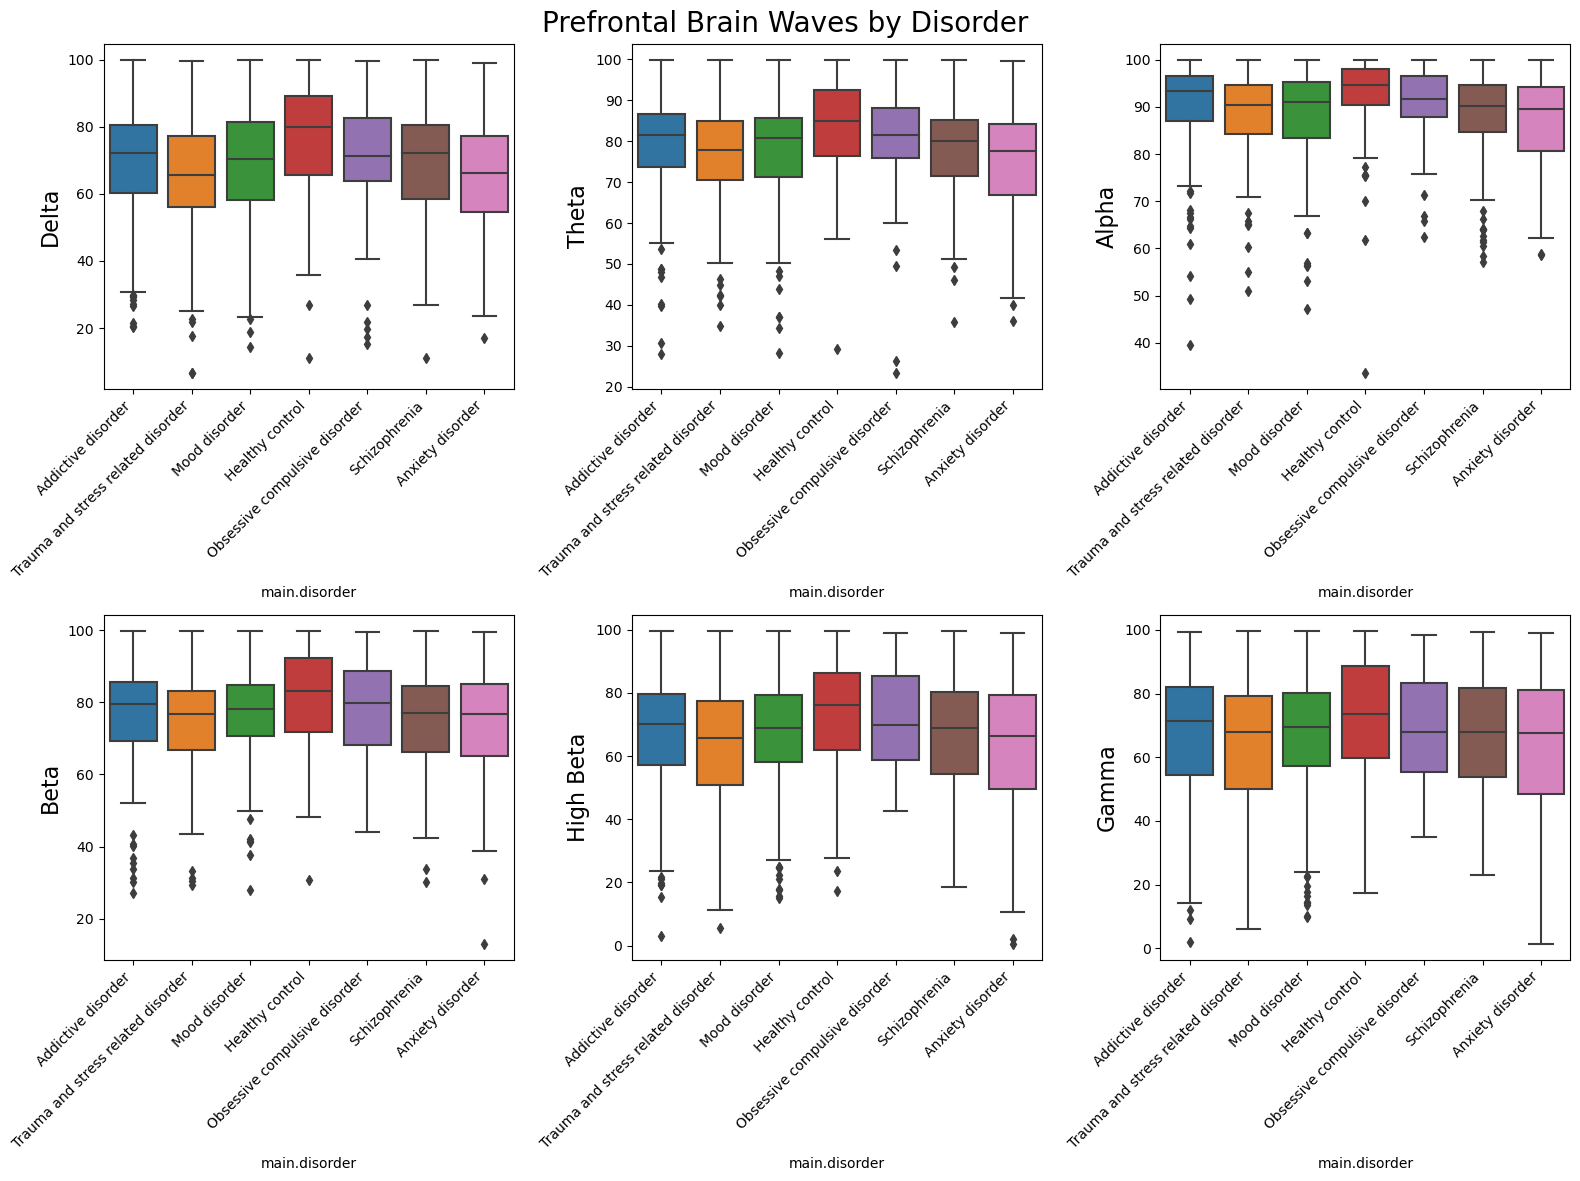

In [45]:
# Boxplot trends for Prefrontal Cortex nodes FP1 and FP2 coherence readings 
# Broken down by the six measured brainwaves

#plt.rcParams["figure.figsize"] = [7.00, 7.00]
#plt.rcParams["figure.autolayout"] = True

fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (16,12))   

#set ax position
ax1 = axes[0][0]
ax2 = axes[0][1]
ax3 = axes[0][2]
ax4 = axes[1][0]
ax5 = axes[1][1]
ax6 = axes[1][2]

fig.suptitle ('Prefrontal Brain Waves by Disorder', size = 20)

# Delta
sns.boxplot(x = df['main.disorder'], y = df['COH.A.delta.a.FP1.b.FP2'], ax = ax1)
# Theta
sns.boxplot(x = df['main.disorder'], y = df['COH.B.theta.a.FP1.b.FP2'], ax = ax2)
# Alpha
sns.boxplot(x = df['main.disorder'], y = df['COH.C.alpha.a.FP1.b.FP2'], ax = ax3)
# Beta
sns.boxplot(x = df['main.disorder'], y = df['COH.D.beta.a.FP1.b.FP2'], ax = ax4)
# High Beta
sns.boxplot(x = df['main.disorder'], y = df['COH.E.highbeta.a.FP1.b.FP2'], ax = ax5)
# Gamma
sns.boxplot(x = df['main.disorder'], y = df['COH.F.gamma.a.FP1.b.FP2'], ax = ax6)


# Set label rotation
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha = 'right')
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha = 'right')
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha = 'right')
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha = 'right')
plt.setp(ax5.xaxis.get_majorticklabels(), rotation=45, ha = 'right')
plt.setp(ax6.xaxis.get_majorticklabels(), rotation=45, ha = 'right')

# Set y label
ax1.set_ylabel("Delta", size = 16)
ax2.set_ylabel("Theta", size = 16)
ax3.set_ylabel("Alpha", size = 16)
ax4.set_ylabel("Beta", size = 16)
ax5.set_ylabel("High Beta", size = 16)
ax6.set_ylabel("Gamma", size = 16)

plt.show();

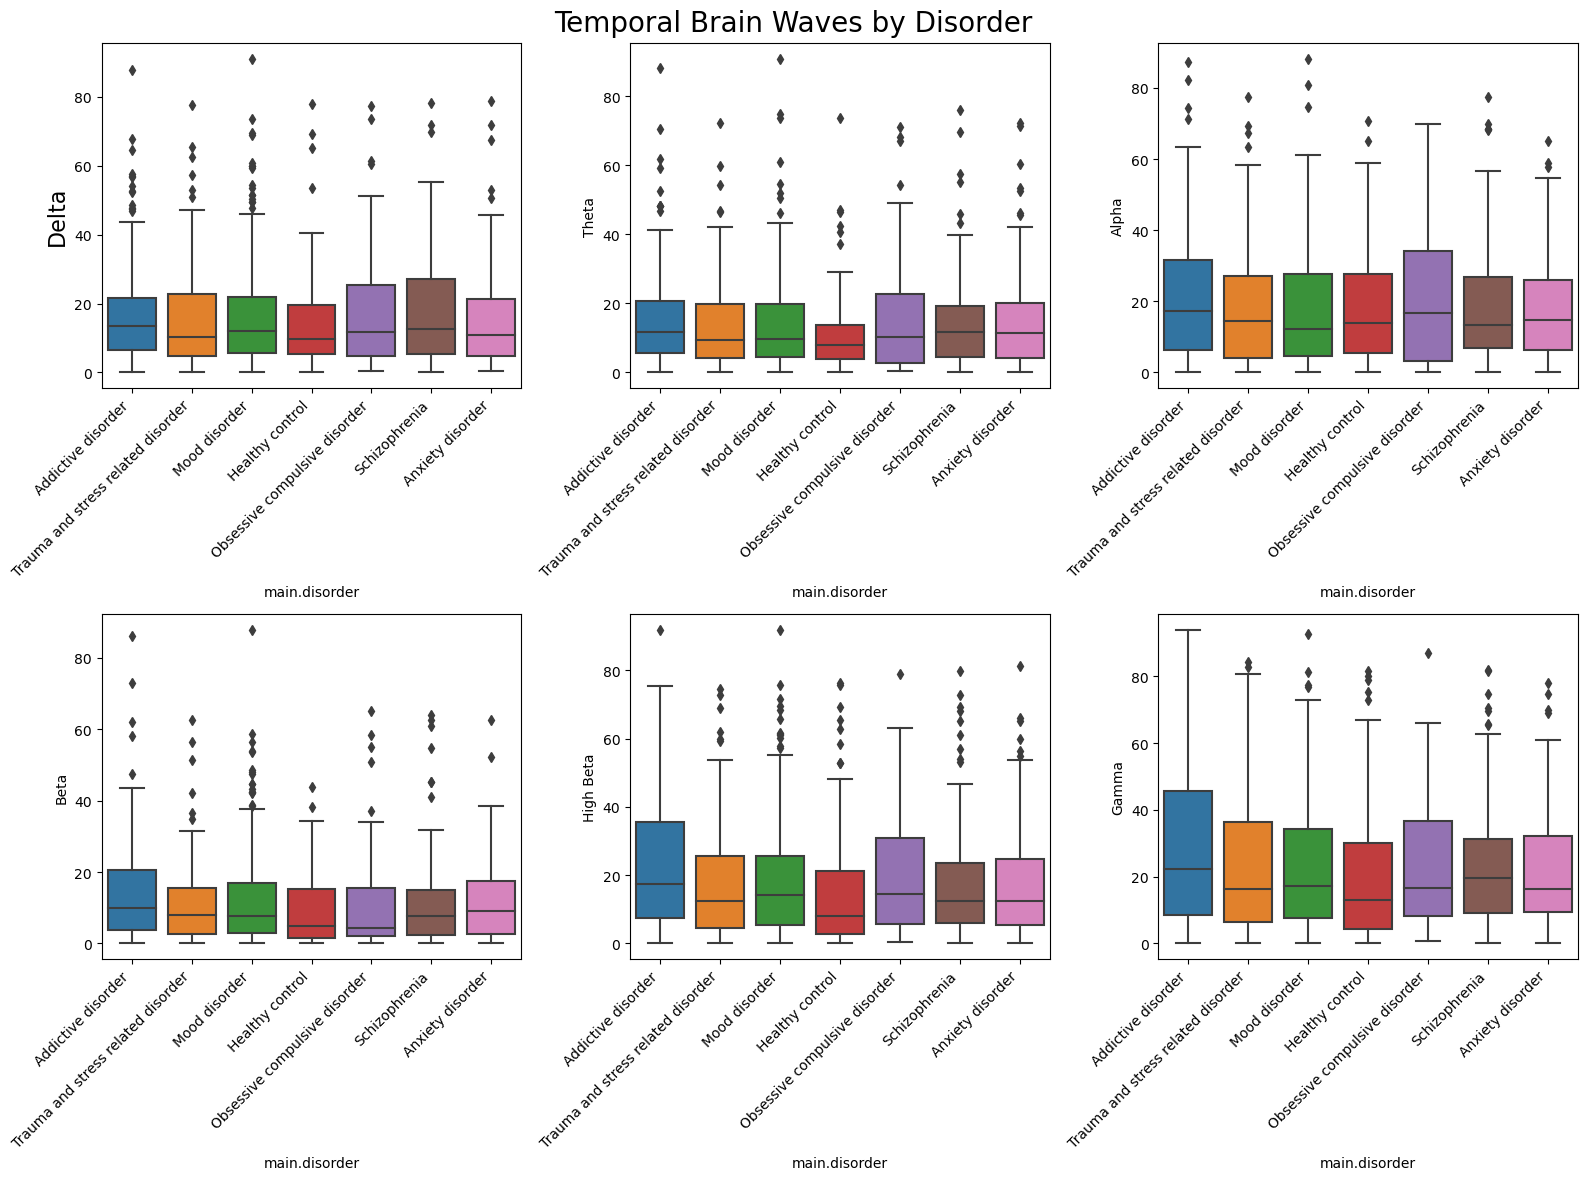

In [44]:
# Boxplots broken down by Temporal Lobes data by brainwave 
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (16,12))   

#set ax position
ax1 = axes[0][0]
ax2 = axes[0][1]
ax3 = axes[0][2]
ax4 = axes[1][0]
ax5 = axes[1][1]
ax6 = axes[1][2]

fig.suptitle ('Temporal Brain Waves by Disorder', size = 20)

# Delta plot
sns.boxplot(x = df['main.disorder'], y = df['COH.A.delta.h.T3.l.T4'], ax = ax1)
# Theta plot
sns.boxplot(x = df['main.disorder'], y = df['COH.B.theta.h.T3.l.T4'], ax = ax2)
# Alpha plot
sns.boxplot(x = df['main.disorder'], y = df['COH.C.alpha.h.T3.l.T4'], ax = ax3)
# Beta plot
sns.boxplot(x = df['main.disorder'], y = df['COH.D.beta.h.T3.l.T4'], ax = ax4)
# High Beta plot
sns.boxplot(x = df['main.disorder'], y = df['COH.E.highbeta.h.T3.l.T4'], ax = ax5)
# Gamma plot
sns.boxplot(x = df['main.disorder'], y = df['COH.F.gamma.h.T3.l.T4'], ax = ax6)

# Set label rotation
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha = 'right')
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha = 'right')
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha = 'right')
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha = 'right')
plt.setp(ax5.xaxis.get_majorticklabels(), rotation=45, ha = 'right')
plt.setp(ax6.xaxis.get_majorticklabels(), rotation=45, ha = 'right')

#Set y labels
ax1.set_ylabel("Delta", size = 16)
ax2.set_ylabel("Theta", size = 16)
ax3.set_ylabel("Alpha", size = 16)
ax4.set_ylabel("Beta", size = 16)
ax5.set_ylabel("High Beta", size = 16)
ax6.set_ylabel("Gamma", size = 16)

fig.tight_layout()
plt.show();

#### Compare Healthy Control against Schizophrenia amd Trauma

In [47]:
# Create dataframe subset for control, schizophrenia and trauma
df_2 = df.loc[df['main.disorder'].isin(['Healthy control', 'Schizophrenia', 'Trauma and stress related disorder'])]

df_2.head()

,no.,sex,age,eeg.date,education,IQ,main.disorder,specific.disorder,AB.A.delta.a.FP1,AB.A.delta.b.FP2,AB.A.delta.c.F7,AB.A.delta.d.F3,AB.A.delta.e.Fz,AB.A.delta.f.F4,AB.A.delta.g.F8,AB.A.delta.h.T3,AB.A.delta.i.C3,AB.A.delta.j.Cz,AB.A.delta.k.C4,AB.A.delta.l.T4,AB.A.delta.m.T5,AB.A.delta.n.P3,AB.A.delta.o.Pz,AB.A.delta.p.P4,AB.A.delta.q.T6,AB.A.delta.r.O1,AB.A.delta.s.O2,AB.B.theta.a.FP1,AB.B.theta.b.FP2,AB.B.theta.c.F7,AB.B.theta.d.F3,AB.B.theta.e.Fz,AB.B.theta.f.F4,AB.B.theta.g.F8,AB.B.theta.h.T3,AB.B.theta.i.C3,AB.B.theta.j.Cz,AB.B.theta.k.C4,AB.B.theta.l.T4,AB.B.theta.m.T5,AB.B.theta.n.P3,AB.B.theta.o.Pz,AB.B.theta.p.P4,AB.B.theta.q.T6,AB.B.theta.r.O1,AB.B.theta.s.O2,AB.C.alpha.a.FP1,AB.C.alpha.b.FP2,AB.C.alpha.c.F7,AB.C.alpha.d.F3,AB.C.alpha.e.Fz,AB.C.alpha.f.F4,AB.C.alpha.g.F8,AB.C.alpha.h.T3,AB.C.alpha.i.C3,AB.C.alpha.j.Cz,AB.C.alpha.k.C4,AB.C.alpha.l.T4,AB.C.alpha.m.T5,AB.C.alpha.n.P3,AB.C.alpha.o.Pz,AB.C.alpha.p.P4,AB.C.alpha.q.T6,AB.C.alpha.r.O1,AB.C.alpha.s.O2,AB.D.beta.a.FP1,AB.D.beta.b.FP2,AB.D.beta.c.F7,AB.D.beta.d.F3,AB.D.beta.e.Fz,AB.D.beta.f.F4,AB.D.beta.g.F8,AB.D.beta.h.T3,AB.D.beta.i.C3,AB.D.beta.j.Cz,AB.D.beta.k.C4,AB.D.beta.l.T4,AB.D.beta.m.T5,AB.D.beta.n.P3,AB.D.beta.o.Pz,AB.D.beta.p.P4,AB.D.beta.q.T6,AB.D.beta.r.O1,AB.D.beta.s.O2,AB.E.highbeta.a.FP1,AB.E.highbeta.b.FP2,AB.E.highbeta.c.F7,AB.E.highbeta.d.F3,AB.E.highbeta.e.Fz,AB.E.highbeta.f.F4,AB.E.highbeta.g.F8,AB.E.highbeta.h.T3,AB.E.highbeta.i.C3,AB.E.highbeta.j.Cz,AB.E.highbeta.k.C4,AB.E.highbeta.l.T4,AB.E.highbeta.m.T5,AB.E.highbeta.n.P3,AB.E.highbeta.o.Pz,AB.E.highbeta.p.P4,AB.E.highbeta.q.T6,AB.E.highbeta.r.O1,AB.E.highbeta.s.O2,AB.F.gamma.a.FP1,AB.F.gamma.b.FP2,AB.F.gamma.c.F7,AB.F.gamma.d.F3,AB.F.gamma.e.Fz,AB.F.gamma.f.F4,AB.F.gamma.g.F8,AB.F.gamma.h.T3,AB.F.gamma.i.C3,AB.F.gamma.j.Cz,AB.F.gamma.k.C4,AB.F.gamma.l.T4,AB.F.gamma.m.T5,AB.F.gamma.n.P3,AB.F.gamma.o.Pz,AB.F.gamma.p.P4,AB.F.gamma.q.T6,AB.F.gamma.r.O1,AB.F.gamma.s.O2,Unnamed: 122,COH.A.delta.a.FP1.b.FP2,COH.A.delta.a.FP1.c.F7,COH.A.delta.a.FP1.d.F3,COH.A.delta.a.FP1.e.Fz,COH.A.delta.a.FP1.f.F4,COH.A.delta.a.FP1.g.F8,COH.A.delta.a.FP1.h.T3,COH.A.delta.a.FP1.i.C3,COH.A.delta.a.FP1.j.Cz,COH.A.delta.a.FP1.k.C4,COH.A.delta.a.FP1.l.T4,COH.A.delta.a.FP1.m.T5,COH.A.delta.a.FP1.n.P3,COH.A.delta.a.FP1.o.Pz,COH.A.delta.a.FP1.p.P4,COH.A.delta.a.FP1.q.T6,COH.A.delta.a.FP1.r.O1,COH.A.delta.a.FP1.s.O2,COH.A.delta.b.FP2.c.F7,COH.A.delta.b.FP2.d.F3,COH.A.delta.b.FP2.e.Fz,COH.A.delta.b.FP2.f.F4,COH.A.delta.b.FP2.g.F8,COH.A.delta.b.FP2.h.T3,COH.A.delta.b.FP2.i.C3,COH.A.delta.b.FP2.j.Cz,COH.A.delta.b.FP2.k.C4,COH.A.delta.b.FP2.l.T4,COH.A.delta.b.FP2.m.T5,COH.A.delta.b.FP2.n.P3,COH.A.delta.b.FP2.o.Pz,COH.A.delta.b.FP2.p.P4,COH.A.delta.b.FP2.q.T6,COH.A.delta.b.FP2.r.O1,COH.A.delta.b.FP2.s.O2,COH.A.delta.c.F7.d.F3,COH.A.delta.c.F7.e.Fz,COH.A.delta.c.F7.f.F4,COH.A.delta.c.F7.g.F8,COH.A.delta.c.F7.h.T3,COH.A.delta.c.F7.i.C3,COH.A.delta.c.F7.j.Cz,COH.A.delta.c.F7.k.C4,COH.A.delta.c.F7.l.T4,COH.A.delta.c.F7.m.T5,COH.A.delta.c.F7.n.P3,COH.A.delta.c.F7.o.Pz,COH.A.delta.c.F7.p.P4,COH.A.delta.c.F7.q.T6,COH.A.delta.c.F7.r.O1,COH.A.delta.c.F7.s.O2,COH.A.delta.d.F3.e.Fz,COH.A.delta.d.F3.f.F4,COH.A.delta.d.F3.g.F8,COH.A.delta.d.F3.h.T3,COH.A.delta.d.F3.i.C3,COH.A.delta.d.F3.j.Cz,COH.A.delta.d.F3.k.C4,COH.A.delta.d.F3.l.T4,COH.A.delta.d.F3.m.T5,COH.A.delta.d.F3.n.P3,COH.A.delta.d.F3.o.Pz,COH.A.delta.d.F3.p.P4,COH.A.delta.d.F3.q.T6,COH.A.delta.d.F3.r.O1,COH.A.delta.d.F3.s.O2,COH.A.delta.e.Fz.f.F4,COH.A.delta.e.Fz.g.F8,COH.A.delta.e.Fz.h.T3,COH.A.delta.e.Fz.i.C3,COH.A.delta.e.Fz.j.Cz,COH.A.delta.e.Fz.k.C4,COH.A.delta.e.Fz.l.T4,COH.A.delta.e.Fz.m.T5,COH.A.delta.e.Fz.n.P3,COH.A.delta.e.Fz.o.Pz,COH.A.delta.e.Fz.p.P4,COH.A.delta.e.Fz.q.T6,COH.A.delta.e.Fz.r.O1,COH.A.delta.e.Fz.s.O2,COH.A.delta.f.F4.g.F8,COH.A.delta.f.F4.h.T3,COH.A.delta.f.F4.i.C3,COH.A.delta.f.F4.j.Cz,COH.A.delta.f.F4.k.C4,COH.A.delta.f.F4.l.T4,COH.A.delta.f.F4.m.T5,COH.A.delta.f.F4.n.P3,COH.A.delta.f.F4.o.Pz,COH.A.delta.f.F4.p.P4,COH.A.delta.f.F4.q.T6,COH.A.de

In [48]:
# check value counts of new dataframe
df_2['main.disorder'].value_counts()

Trauma and stress related disorder    128
Schizophrenia                         117
Healthy control                        95
Name: main.disorder, dtype: int64

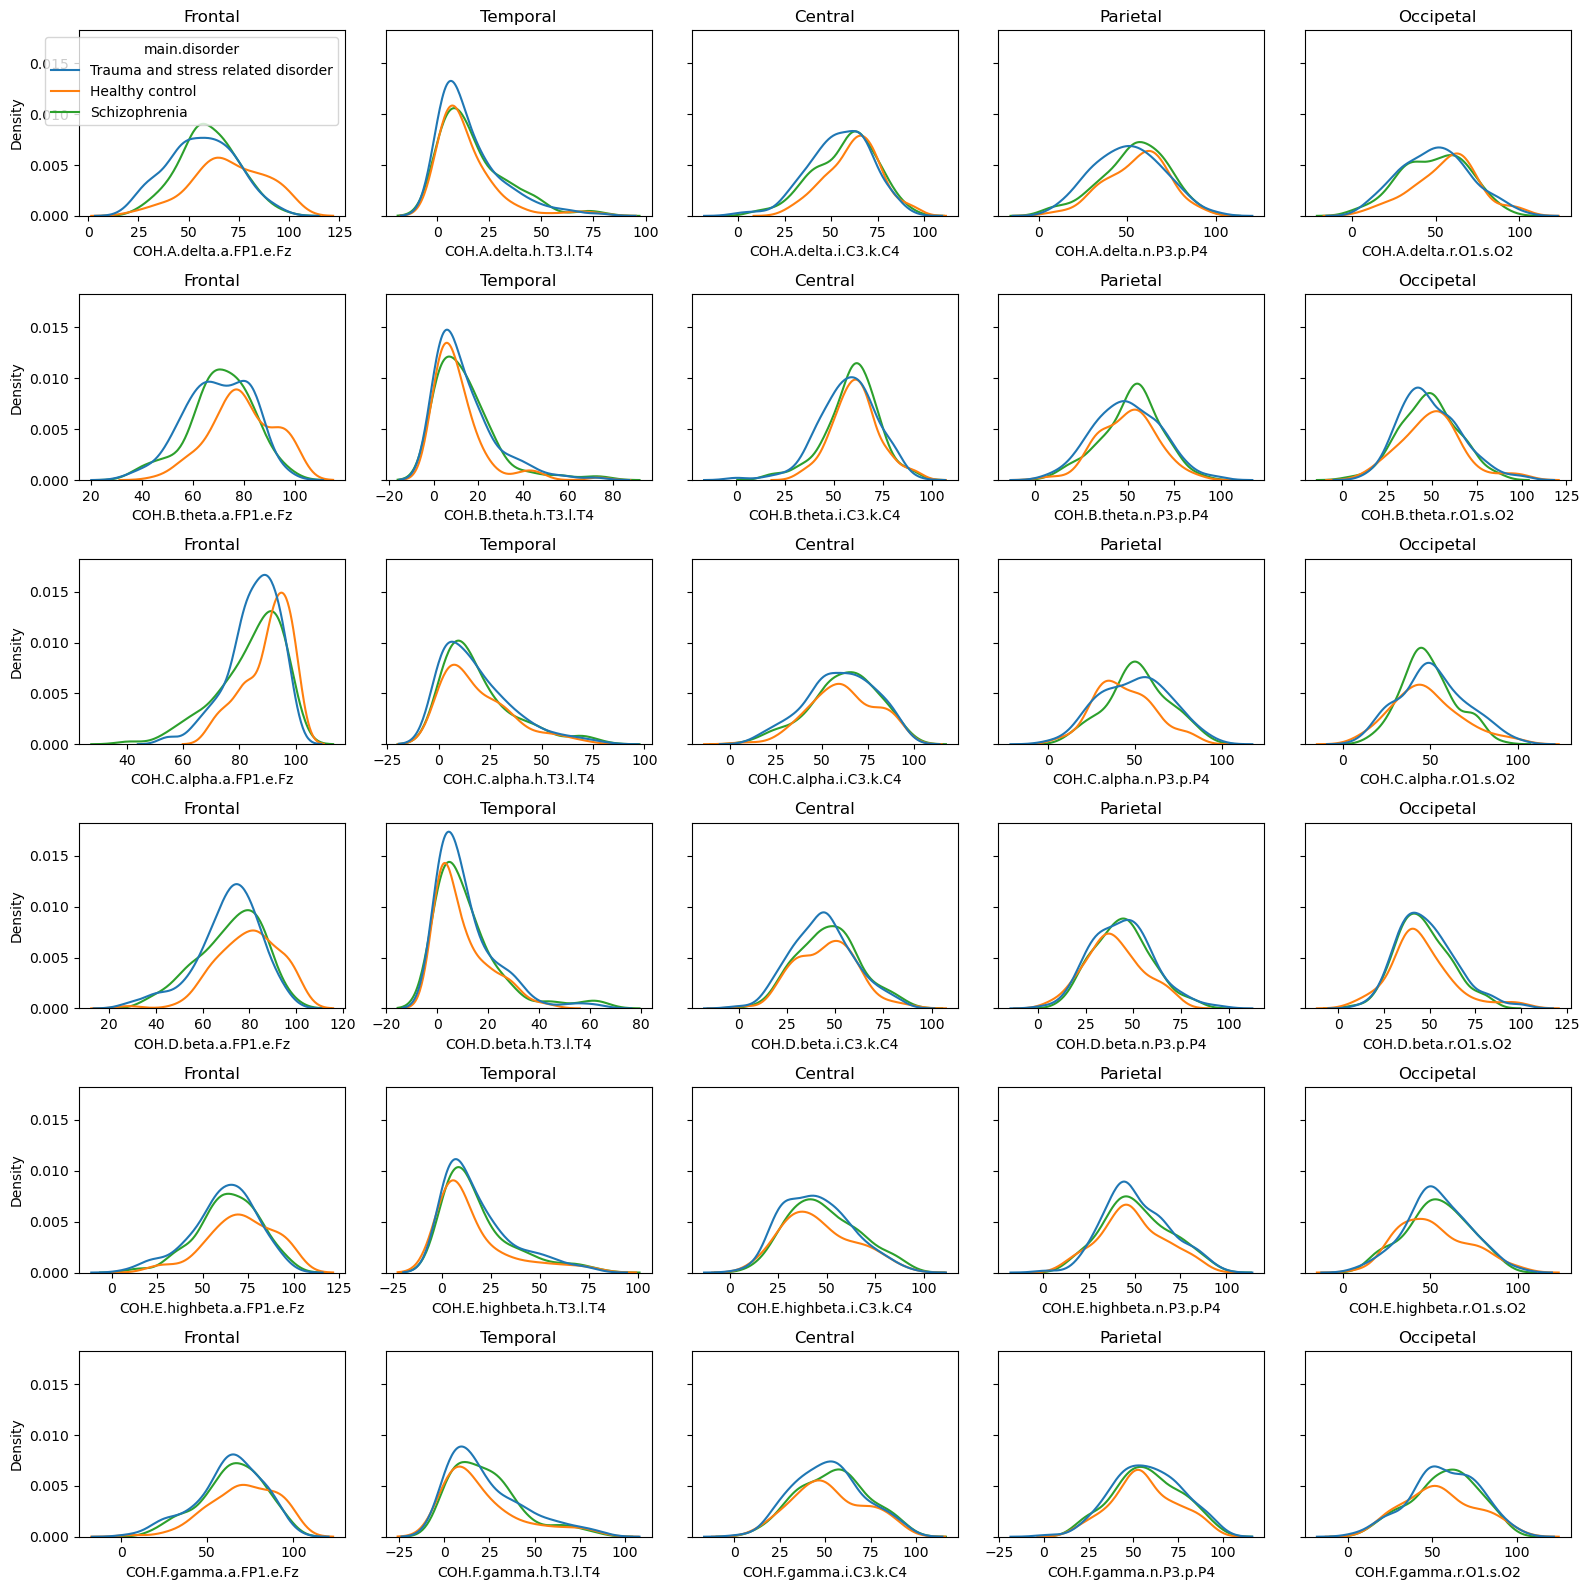

In [51]:
# Density Plot by each brainwave for each major brain region
# Brain Regions: Frontal, Temporal, Central, Parietal, Occipetal

fig, axes = plt.subplots(6, 5, figsize = (16,16), sharey = True)

# Delta (δ)	0.5–4 Hz	Sleep dominant
sns.kdeplot(data = df_2, x="COH.A.delta.a.FP1.e.Fz", hue="main.disorder", 
            ax = axes[0][0], legend = True).set(title = 'Frontal')
sns.kdeplot(data = df_2, x="COH.A.delta.h.T3.l.T4", hue="main.disorder", 
            ax = axes[0][1], legend = False).set(title = 'Temporal')
sns.kdeplot(data = df_2, x="COH.A.delta.i.C3.k.C4", hue="main.disorder", 
            ax = axes[0][2], legend = False).set(title = 'Central')
sns.kdeplot(data = df_2, x="COH.A.delta.n.P3.p.P4", hue="main.disorder", 
            ax = axes[0][3], legend = False).set(title = 'Parietal')
sns.kdeplot(data = df_2, x="COH.A.delta.r.O1.s.O2", hue="main.disorder", 
            ax = axes[0][4], legend = False).set(title = 'Occipetal')

# Theta (θ)	4–8 Hz	Deeply relaxed, inward focused
sns.kdeplot(data = df_2, x="COH.B.theta.a.FP1.e.Fz", hue="main.disorder", 
            ax = axes[1][0], legend = False).set(title = 'Frontal')
sns.kdeplot(data = df_2, x="COH.B.theta.h.T3.l.T4", hue="main.disorder", 
            ax = axes[1][1], legend = False).set(title = 'Temporal')
sns.kdeplot(data = df_2, x="COH.B.theta.i.C3.k.C4", hue="main.disorder", 
            ax = axes[1][2], legend = False).set(title = 'Central')
sns.kdeplot(data = df_2, x="COH.B.theta.n.P3.p.P4", hue="main.disorder", 
            ax = axes[1][3], legend = False).set(title = 'Parietal')
sns.kdeplot(data = df_2, x="COH.B.theta.r.O1.s.O2", hue="main.disorder", 
            ax = axes[1][4], legend = False).set(title = 'Occipetal')

# Alpha (α)	8–12 Hz	Very relaxed, passive attention
sns.kdeplot(data = df_2, x="COH.C.alpha.a.FP1.e.Fz", hue="main.disorder", 
            ax = axes[2][0], legend = False).set(title = 'Frontal')
sns.kdeplot(data = df_2, x="COH.C.alpha.h.T3.l.T4", hue="main.disorder", 
            ax = axes[2][1], legend = False).set(title = 'Temporal')
sns.kdeplot(data = df_2, x="COH.C.alpha.i.C3.k.C4", hue="main.disorder", 
            ax = axes[2][2], legend = False).set(title = 'Central')
sns.kdeplot(data = df_2, x="COH.C.alpha.n.P3.p.P4", hue="main.disorder", 
            ax = axes[2][3], legend = False).set(title = 'Parietal')
sns.kdeplot(data = df_2, x="COH.C.alpha.r.O1.s.O2", hue="main.disorder", 
            ax = axes[2][4], legend = False).set(title = 'Occipetal')

# Beta (β)	12–35 Hz  Anxiety dominant, active, external attention, relaxed
sns.kdeplot(data = df_2, x="COH.D.beta.a.FP1.e.Fz", hue="main.disorder", 
            ax = axes[3][0], legend = False).set(title = 'Frontal')
sns.kdeplot(data = df_2, x="COH.D.beta.h.T3.l.T4", hue="main.disorder", 
            ax = axes[3][1], legend = False).set(title = 'Temporal')
sns.kdeplot(data = df_2, x="COH.D.beta.i.C3.k.C4", hue="main.disorder", 
            ax = axes[3][2], legend = False).set(title = 'Central')
sns.kdeplot(data = df_2, x="COH.D.beta.n.P3.p.P4", hue="main.disorder", 
            ax = axes[3][3], legend = False).set(title = 'Parietal')
sns.kdeplot(data = df_2, x="COH.D.beta.r.O1.s.O2", hue="main.disorder", 
            ax = axes[3][4], legend = False).set(title = 'Occipetal')

# High beta
sns.kdeplot(data = df_2, x="COH.E.highbeta.a.FP1.e.Fz", hue="main.disorder", 
            ax = axes[4][0], legend = False).set(title = 'Frontal')
sns.kdeplot(data = df_2, x="COH.E.highbeta.h.T3.l.T4", hue="main.disorder", 
            ax = axes[4][1], legend = False).set(title = 'Temporal')
sns.kdeplot(data = df_2, x="COH.E.highbeta.i.C3.k.C4", hue="main.disorder", 
            ax = axes[4][2], legend = False).set(title = 'Central')
sns.kdeplot(data = df_2, x="COH.E.highbeta.n.P3.p.P4", hue="main.disorder", 
            ax = axes[4][3], legend = False).set(title = 'Parietal')
sns.kdeplot(data = df_2, x="COH.E.highbeta.r.O1.s.O2", hue="main.disorder", 
            ax = axes[4][4], legend = False).set(title = 'Occipetal')

# Gamma (γ)	35 Hz and greater 	Concentration
sns.kdeplot(data = df_2, x="COH.F.gamma.a.FP1.e.Fz", hue="main.disorder", 
            ax = axes[5][0], legend = False).set(title = 'Frontal')
sns.kdeplot(data = df_2, x="COH.F.gamma.h.T3.l.T4", hue="main.disorder", 
            ax = axes[5][1], legend = False).set(title = 'Temporal')
sns.kdeplot(data = df_2, x="COH.F.gamma.i.C3.k.C4", hue="main.disorder", 
            ax = axes[5][2], legend = False).set(title = 'Central')
sns.kdeplot(data = df_2, x="COH.F.gamma.n.P3.p.P4", hue="main.disorder", 
            ax = axes[5][3], legend = False).set(title = 'Parietal')
sns.kdeplot(data = df_2, x="COH.F.gamma.r.O1.s.O2", hue="main.disorder", 
            ax = axes[5][4], legend = False).set(title = 'Occipetal')

fig.tight_layout()
plt.show;

#### Brief Summary of EDA
1. Patient stats
2. patient EEG readings
3. Scaling of data
4. EEG reading trends overall
5. EEG readings for subset

### 4. Preprocessing data 
1. Plan for missing data
2. Drop unnecessary rows
3. Split data into target and data
4. Make plan to balance targets - balanced in SMOTE
5. Convert male - female into binary
6. Make all data numeric if possible

In [52]:
# Drop columns from feature list: no., date, and Unnamed: 122
# Drop specific disorder to avoid multicollinearity with Main disorder

data = df.drop(['no.', 'eeg.date', 'specific.disorder', 'Unnamed: 122'], axis = 1)
data.head()

,sex,age,education,IQ,main.disorder,AB.A.delta.a.FP1,AB.A.delta.b.FP2,AB.A.delta.c.F7,AB.A.delta.d.F3,AB.A.delta.e.Fz,AB.A.delta.f.F4,AB.A.delta.g.F8,AB.A.delta.h.T3,AB.A.delta.i.C3,AB.A.delta.j.Cz,AB.A.delta.k.C4,AB.A.delta.l.T4,AB.A.delta.m.T5,AB.A.delta.n.P3,AB.A.delta.o.Pz,AB.A.delta.p.P4,AB.A.delta.q.T6,AB.A.delta.r.O1,AB.A.delta.s.O2,AB.B.theta.a.FP1,AB.B.theta.b.FP2,AB.B.theta.c.F7,AB.B.theta.d.F3,AB.B.theta.e.Fz,AB.B.theta.f.F4,AB.B.theta.g.F8,AB.B.theta.h.T3,AB.B.theta.i.C3,AB.B.theta.j.Cz,AB.B.theta.k.C4,AB.B.theta.l.T4,AB.B.theta.m.T5,AB.B.theta.n.P3,AB.B.theta.o.Pz,AB.B.theta.p.P4,AB.B.theta.q.T6,AB.B.theta.r.O1,AB.B.theta.s.O2,AB.C.alpha.a.FP1,AB.C.alpha.b.FP2,AB.C.alpha.c.F7,AB.C.alpha.d.F3,AB.C.alpha.e.Fz,AB.C.alpha.f.F4,AB.C.alpha.g.F8,AB.C.alpha.h.T3,AB.C.alpha.i.C3,AB.C.alpha.j.Cz,AB.C.alpha.k.C4,AB.C.alpha.l.T4,AB.C.alpha.m.T5,AB.C.alpha.n.P3,AB.C.alpha.o.Pz,AB.C.alpha.p.P4,AB.C.alpha.q.T6,AB.C.alpha.r.O1,AB.C.alpha.s.O2,AB.D.beta.a.FP1,AB.D.beta.b.FP2,AB.D.beta.c.F7,AB.D.beta.d.F3,AB.D.beta.e.Fz,AB.D.beta.f.F4,AB.D.beta.g.F8,AB.D.beta.h.T3,AB.D.beta.i.C3,AB.D.beta.j.Cz,AB.D.beta.k.C4,AB.D.beta.l.T4,AB.D.beta.m.T5,AB.D.beta.n.P3,AB.D.beta.o.Pz,AB.D.beta.p.P4,AB.D.beta.q.T6,AB.D.beta.r.O1,AB.D.beta.s.O2,AB.E.highbeta.a.FP1,AB.E.highbeta.b.FP2,AB.E.highbeta.c.F7,AB.E.highbeta.d.F3,AB.E.highbeta.e.Fz,AB.E.highbeta.f.F4,AB.E.highbeta.g.F8,AB.E.highbeta.h.T3,AB.E.highbeta.i.C3,AB.E.highbeta.j.Cz,AB.E.highbeta.k.C4,AB.E.highbeta.l.T4,AB.E.highbeta.m.T5,AB.E.highbeta.n.P3,AB.E.highbeta.o.Pz,AB.E.highbeta.p.P4,AB.E.highbeta.q.T6,AB.E.highbeta.r.O1,AB.E.highbeta.s.O2,AB.F.gamma.a.FP1,AB.F.gamma.b.FP2,AB.F.gamma.c.F7,AB.F.gamma.d.F3,AB.F.gamma.e.Fz,AB.F.gamma.f.F4,AB.F.gamma.g.F8,AB.F.gamma.h.T3,AB.F.gamma.i.C3,AB.F.gamma.j.Cz,AB.F.gamma.k.C4,AB.F.gamma.l.T4,AB.F.gamma.m.T5,AB.F.gamma.n.P3,AB.F.gamma.o.Pz,AB.F.gamma.p.P4,AB.F.gamma.q.T6,AB.F.gamma.r.O1,AB.F.gamma.s.O2,COH.A.delta.a.FP1.b.FP2,COH.A.delta.a.FP1.c.F7,COH.A.delta.a.FP1.d.F3,COH.A.delta.a.FP1.e.Fz,COH.A.delta.a.FP1.f.F4,COH.A.delta.a.FP1.g.F8,COH.A.delta.a.FP1.h.T3,COH.A.delta.a.FP1.i.C3,COH.A.delta.a.FP1.j.Cz,COH.A.delta.a.FP1.k.C4,COH.A.delta.a.FP1.l.T4,COH.A.delta.a.FP1.m.T5,COH.A.delta.a.FP1.n.P3,COH.A.delta.a.FP1.o.Pz,COH.A.delta.a.FP1.p.P4,COH.A.delta.a.FP1.q.T6,COH.A.delta.a.FP1.r.O1,COH.A.delta.a.FP1.s.O2,COH.A.delta.b.FP2.c.F7,COH.A.delta.b.FP2.d.F3,COH.A.delta.b.FP2.e.Fz,COH.A.delta.b.FP2.f.F4,COH.A.delta.b.FP2.g.F8,COH.A.delta.b.FP2.h.T3,COH.A.delta.b.FP2.i.C3,COH.A.delta.b.FP2.j.Cz,COH.A.delta.b.FP2.k.C4,COH.A.delta.b.FP2.l.T4,COH.A.delta.b.FP2.m.T5,COH.A.delta.b.FP2.n.P3,COH.A.delta.b.FP2.o.Pz,COH.A.delta.b.FP2.p.P4,COH.A.delta.b.FP2.q.T6,COH.A.delta.b.FP2.r.O1,COH.A.delta.b.FP2.s.O2,COH.A.delta.c.F7.d.F3,COH.A.delta.c.F7.e.Fz,COH.A.delta.c.F7.f.F4,COH.A.delta.c.F7.g.F8,COH.A.delta.c.F7.h.T3,COH.A.delta.c.F7.i.C3,COH.A.delta.c.F7.j.Cz,COH.A.delta.c.F7.k.C4,COH.A.delta.c.F7.l.T4,COH.A.delta.c.F7.m.T5,COH.A.delta.c.F7.n.P3,COH.A.delta.c.F7.o.Pz,COH.A.delta.c.F7.p.P4,COH.A.delta.c.F7.q.T6,COH.A.delta.c.F7.r.O1,COH.A.delta.c.F7.s.O2,COH.A.delta.d.F3.e.Fz,COH.A.delta.d.F3.f.F4,COH.A.delta.d.F3.g.F8,COH.A.delta.d.F3.h.T3,COH.A.delta.d.F3.i.C3,COH.A.delta.d.F3.j.Cz,COH.A.delta.d.F3.k.C4,COH.A.delta.d.F3.l.T4,COH.A.delta.d.F3.m.T5,COH.A.delta.d.F3.n.P3,COH.A.delta.d.F3.o.Pz,COH.A.delta.d.F3.p.P4,COH.A.delta.d.F3.q.T6,COH.A.delta.d.F3.r.O1,COH.A.delta.d.F3.s.O2,COH.A.delta.e.Fz.f.F4,COH.A.delta.e.Fz.g.F8,COH.A.delta.e.Fz.h.T3,COH.A.delta.e.Fz.i.C3,COH.A.delta.e.Fz.j.Cz,COH.A.delta.e.Fz.k.C4,COH.A.delta.e.Fz.l.T4,COH.A.delta.e.Fz.m.T5,COH.A.delta.e.Fz.n.P3,COH.A.delta.e.Fz.o.Pz,COH.A.delta.e.Fz.p.P4,COH.A.delta.e.Fz.q.T6,COH.A.delta.e.Fz.r.O1,COH.A.delta.e.Fz.s.O2,COH.A.delta.f.F4.g.F8,COH.A.delta.f.F4.h.T3,COH.A.delta.f.F4.i.C3,COH.A.delta.f.F4.j.Cz,COH.A.delta.f.F4.k.C4,COH.A.delta.f.F4.l.T4,COH.A.delta.f.F4.m.T5,COH.A.delta.f.F4.n.P3,COH.A.delta.f.F4.o.Pz,COH.A.delta.f.F4.p.P4,COH.A.delta.f.F4.q.T6,COH.A.delta.f.F4.r.O1,COH.A.delta.f.F4.s.O2,COH.A.de

In [53]:
# Display column names with missing data

print(data.columns[data.isnull().any()])


Index(['education', 'IQ'], dtype='object')


In [54]:
# Replace education and IQ columns with median
data[['education', 'IQ']] = data[['education', 'IQ']].fillna(data[['education', 'IQ']].median())

In [55]:
X = data.drop(['main.disorder'], axis = 1)
y = data['main.disorder']

In [56]:
y.value_counts(normalize = True)

Mood disorder                         0.281481
Addictive disorder                    0.196825
Trauma and stress related disorder    0.135450
Schizophrenia                         0.123810
Anxiety disorder                      0.113228
Healthy control                       0.100529
Obsessive compulsive disorder         0.048677
Name: main.disorder, dtype: float64

#### Train Test Split using Shuffle Stratified Split

In [58]:
# Use stratified split for balanced split among target categories

from sklearn.model_selection import StratifiedShuffleSplit 

sss=StratifiedShuffleSplit(n_splits=1,random_state=42) 

sss.get_n_splits(X, y)

for train,test in sss.split(X,y):     #this will split the index
    X_train = X.iloc[train]
    y_train = y.iloc[train]
    X_test = X.iloc[test]
    y_test = y.iloc[test]

print('Comparison of category split between Train and Test set')
print()
print('Train target category percentage split')
print()
print(y_train.value_counts(normalize = True))  
print()
print('Test target category percentage split')
print()
print(y_test.value_counts(normalize = True))

Comparison of category split between Train and Test set

Train target category percentage split

Mood disorder                         0.281176
Addictive disorder                    0.196471
Trauma and stress related disorder    0.135294
Schizophrenia                         0.123529
Anxiety disorder                      0.112941
Healthy control                       0.101176
Obsessive compulsive disorder         0.049412
Name: main.disorder, dtype: float64

Test target category percentage split

Mood disorder                         0.284211
Addictive disorder                    0.200000
Trauma and stress related disorder    0.136842
Schizophrenia                         0.126316
Anxiety disorder                      0.115789
Healthy control                       0.094737
Obsessive compulsive disorder         0.042105
Name: main.disorder, dtype: float64


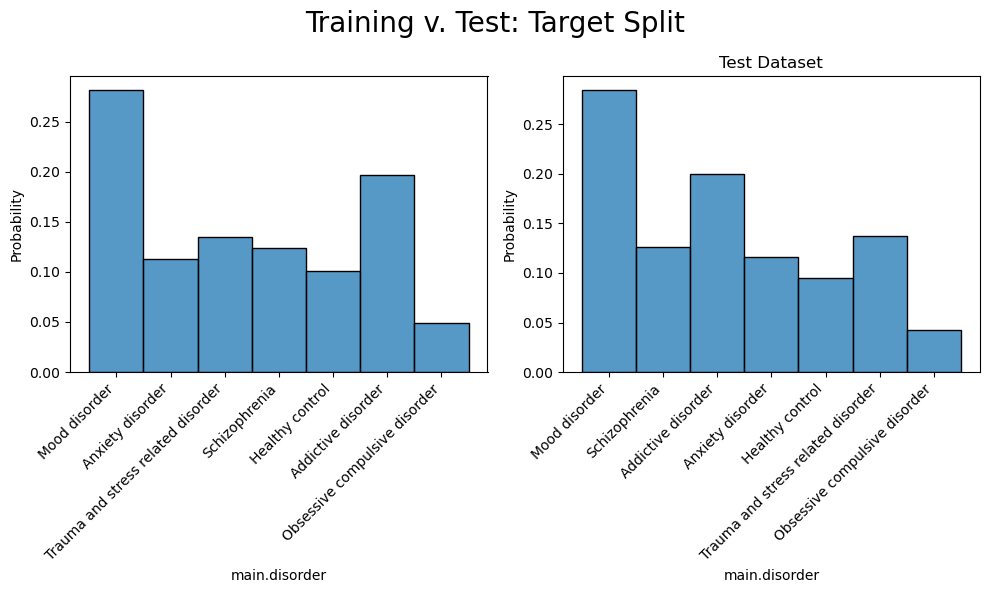

In [60]:
import warnings
warnings.filterwarnings("ignore")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,6))  


fig.suptitle ('Training v. Test: Target Split', size = 20)

sns.histplot(x = y_train, stat = 'probability', ax = ax1)
plt.title('Training Dataset')

sns.histplot(x = y_test, stat = 'probability', ax = ax2)
plt.title('Test Dataset')

plt.draw()

ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha = 'right')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha = 'right');
plt.tight_layout();

### 5. Modeling

#### First simple model - unpruned decision tree or KNN model

In [61]:
X_train.columns

Index(['sex', 'age', 'education', 'IQ', 'AB.A.delta.a.FP1', 'AB.A.delta.b.FP2',
       'AB.A.delta.c.F7', 'AB.A.delta.d.F3', 'AB.A.delta.e.Fz',
       'AB.A.delta.f.F4',
       ...
       'COH.F.gamma.o.Pz.p.P4', 'COH.F.gamma.o.Pz.q.T6',
       'COH.F.gamma.o.Pz.r.O1', 'COH.F.gamma.o.Pz.s.O2',
       'COH.F.gamma.p.P4.q.T6', 'COH.F.gamma.p.P4.r.O1',
       'COH.F.gamma.p.P4.s.O2', 'COH.F.gamma.q.T6.r.O1',
       'COH.F.gamma.q.T6.s.O2', 'COH.F.gamma.r.O1.s.O2'],
      dtype='object', length=1144)

In [62]:
# create subpipe for categorical data: gender
subpipe_cat = Pipeline(steps=[('ohe', OneHotEncoder())])

# create subpipe for numeric data: impute median for missing data, standard scale
subpipe_num = Pipeline(steps=[('mms', MinMaxScaler())])

# combine subpipes into ColumnTransformer, assign column locations to features

CT = ColumnTransformer(transformers=[('subpipe_cat', subpipe_cat, [0]),
                                    ('subpipe_num', subpipe_num, slice(1,1143))],
                                     remainder = 'passthrough', n_jobs = -1)


In [63]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit_transform(y_train);

In [64]:
from sklearn.neighbors import KNeighborsClassifier
knn_pipe = Pipeline(steps = [('ct', CT), 
                           ('knn', KNeighborsClassifier(n_neighbors = 5, weights = 'uniform'))])

knn_pipe.fit(X_train, y_train)



Pipeline(steps=[('ct',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder())]),
                                                  [0]),
                                                 ('subpipe_num',
                                                  Pipeline(steps=[('mms',
                                                                   MinMaxScaler())]),
                                                  slice(1, 1143, None))])),
                ('knn', KNeighborsClassifier())])

In [65]:
dtc_pipe = Pipeline(steps = [('ct', CT), 
                           ('dtc', DecisionTreeClassifier(random_state = 42))])
dtc_pipe.fit(X_train, y_train)
dtc_pipe.score(X_train, y_train)

1.0

In [66]:
y_hat_dtc = dtc_pipe.predict(X_test)

In [67]:
print(classification_report(y_test, y_hat_dtc))

                                    precision    recall  f1-score   support

                Addictive disorder       0.29      0.21      0.24        19
                  Anxiety disorder       0.05      0.09      0.06        11
                   Healthy control       0.21      0.33      0.26         9
                     Mood disorder       0.29      0.22      0.25        27
     Obsessive compulsive disorder       0.00      0.00      0.00         4
                     Schizophrenia       0.27      0.25      0.26        12
Trauma and stress related disorder       0.09      0.08      0.08        13

                          accuracy                           0.19        95
                         macro avg       0.17      0.17      0.17        95
                      weighted avg       0.21      0.19      0.20        95



In [69]:
# Instantiate a Random Forest Classifier

rfc = RandomForestClassifier(random_state=42)



# Create pipeline

rfc_pipe = Pipeline(steps=[('ct', CT), ('rfc', rfc)])
rfc_pipe.fit(X_train, y_train)



TypeError: All intermediate steps should be transformers and implement fit and transform or be the string 'passthrough' 'RandomForestClassifier(random_state=42)' (type <class 'sklearn.ensemble._forest.RandomForestClassifier'>) doesn't

In [41]:
rfc_pipe.score(X_train, y_train)

1.0

In [42]:
y_hat_rfc = rfc_pipe.predict(X_test)

In [43]:
print(classification_report(y_test, y_hat_rfc))

                                    precision    recall  f1-score   support

                Addictive disorder       0.37      0.37      0.37        19
                  Anxiety disorder       0.50      0.09      0.15        11
                   Healthy control       1.00      0.22      0.36         9
                     Mood disorder       0.28      0.67      0.39        27
     Obsessive compulsive disorder       0.00      0.00      0.00         4
                     Schizophrenia       0.00      0.00      0.00        12
Trauma and stress related disorder       0.33      0.15      0.21        13

                          accuracy                           0.32        95
                         macro avg       0.35      0.21      0.21        95
                      weighted avg       0.35      0.32      0.27        95



In [44]:
# Grid Search for Random Forest 
# Grid Search for better model criteria 

params = {'rfc__n_estimators': [10],
          'rfc__criterion': ['gini'],
          'rfc__min_samples_leaf': [1, 5, 10],
          'rfc__max_depth': [1, 5, 9],
          'rfc__max_features': [9]
          }

gs_rfc = GridSearchCV(estimator=rfc_pipe,
                 param_grid=params, n_jobs = -1,
                 cv=3)

In [45]:
gs_rfc.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(n_jobs=-1,
                                                          remainder='passthrough',
                                                          transformers=[('subpipe_cat',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder())]),
                                                                         [0]),
                                                                        ('subpipe_num',
                                                                         Pipeline(steps=[('mms',
                                                                                          MinMaxScaler())]),
                                                                         slice(1, 1143, None))])),
                                       ('rfc',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'rfc__criterion': ['gini'],
                         'rfc__max_depth': [1, 5, 9], 'rfc__max_features': [9],
                         'rfc__min_samples_leaf': [1, 5, 10],
                         'rfc__n_estimators': [10]})

In [46]:
# Best parameters for further tuning
gs_rfc.best_params_

{'rfc__criterion': 'gini',
 'rfc__max_depth': 9,
 'rfc__max_features': 9,
 'rfc__min_samples_leaf': 10,
 'rfc__n_estimators': 10}

In [47]:
gs_rfc.score(X_train, y_train)

0.5694117647058824

In [48]:
y_hat_gs_rfc = gs_rfc.predict(X_test)

In [49]:
print(classification_report(y_test, y_hat_gs_rfc))

                                    precision    recall  f1-score   support

                Addictive disorder       0.12      0.11      0.11        19
                  Anxiety disorder       0.00      0.00      0.00        11
                   Healthy control       1.00      0.22      0.36         9
                     Mood disorder       0.30      0.70      0.42        27
     Obsessive compulsive disorder       0.00      0.00      0.00         4
                     Schizophrenia       0.00      0.00      0.00        12
Trauma and stress related disorder       0.33      0.23      0.27        13

                          accuracy                           0.27        95
                         macro avg       0.25      0.18      0.17        95
                      weighted avg       0.25      0.27      0.21        95



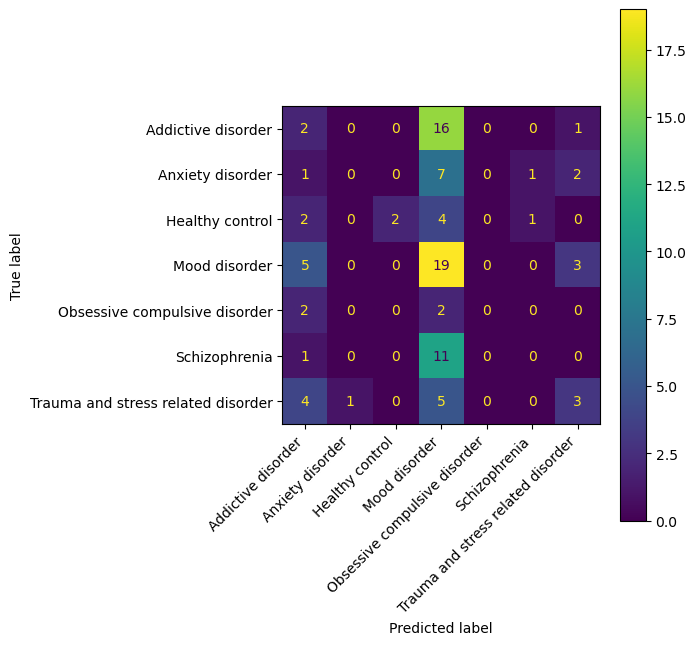

In [63]:
cm = confusion_matrix(y_test, y_hat_gs_rfc, labels=gs_rfc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=gs_rfc.classes_)
disp.plot()
plt.xticks(rotation = 45, ha = 'right')
plt.show()